# Fully Connected Neural Networks from scratch

**Aim:** <br>

Use the MNIST data set and implement the forward
and backward passes for fully-connected deep neural networks from scratch.

**Model Explanation:** <br>

First, let us preprocess the data. We load the training and testing data from the MNIST
dataset, consisting of 60,000 training images + labels, and 10,000 testing images + labels. Next,
we normalize the image data by dividing each pixel by 255.0 and reshape the labels. Now, we
encode the class value of the labels into one-hot vectors to avoid bias implied by the label
value.

In [ ]:
import sklearn
from keras.datasets import mnist
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# import
(train_X, train_y), (test_X, test_y) = mnist.load_data()

# scale
train_X = train_X.astype(np.float16) / 255.0
test_X = test_X.astype(np.float16) / 255.0

# reshape
train_y = np.array(train_y, dtype = np.float16)
train_y = train_y.reshape(train_y.shape[0],1)

test_y = np.array(test_y, dtype = np.float16)
test_y = test_y.reshape(test_y.shape[0],1)


11493376/11490434 [==============================] - 0s 0us/step


In [ ]:
print(train_X.shape)
print(test_X.shape)
print(train_y.shape)
print(test_y.shape)
print(np.unique(train_y))
print(np.unique(test_y))

(60000, 28, 28)
(10000, 28, 28)
(60000, 1)
(10000, 1)
[0. 1. 2. 3. 4. 5. 6. 7. 8. 9.]
[0. 1. 2. 3. 4. 5. 6. 7. 8. 9.]


In [ ]:
def one_hot_encode(j):
    # Convert the labels to a one-hot encoding scheme.
    e = np.zeros((10, 1))
    e[j] = 1.0
    return e

training_inputs = [np.reshape(x, (784, 1)) for x in train_X]
training_results = [one_hot_encode(int(y)) for y in train_y]
training_data = [list(a) for a in zip(training_inputs, training_results)]

test_inputs = [np.reshape(x, (784, 1)) for x in test_X]
test_results = [one_hot_encode(int(y)) for y in test_y]
test_data = [list(a) for a in zip(test_inputs, test_results)]

In [ ]:
print(type(training_data))
print(len(training_data))
print(type(test_results))
print(len(test_results))

<class 'list'>
60000
<class 'list'>
10000


Now, to build the model, we define a class named as Network which initializes the number of
layers, number of nodes in a layer, weights, and biases of the network. Next, we define the
forward and backward pass of backpropagation together in a function named as ’backprop’.
For the forward pass, we compute the sublinear layer as z = wx + b and then apply the
Sigmoid activation function for the last layer and ReLu activation function for all other layers
to compute the activations, given by a = Relu(z) or a = Sigmoid(z). For the backward pass,
we compute the error term for the last layer by multiplying the cost gradient and the gradient
for the Sigmoid activation function. For all other layers from the second last layer to the first
layer, we compute the error term by multiplying the cost gradient and the gradient for the
Relu activation function. Then, we update the weights and bias in the backward pass given
by: dw<sup>(l)</sup> = e<sup>(l)</sup>
z<sub>(l−1)</sub><sup>T</sup>
and db<sup>(l)</sup> = e<sup>(l)</sup>. This completes the backprop.


Now, to train the model, we first create a network with 2 hidden layers given by
Network([784, 30, 30, 10]) where the first parameter is the dimension of the input data and
hence the first layer is the input layer, the second and third layers correspond to the hidden
layers with 30 neurons each, and the fourth layer corresponds to the output layer with 10
nodes corresponding to the 10 class labels. Next, we call the sgd function which creates mini
batches for the data and passes to the ’update mini batch’ function. The update mini batch function initiates backpropagation for each data point in the mini batch and updates the
weights and biases of the network. Finally, the error and accuracy are calculated in the sgd
function and are printed with respect to each epoch. The losses and accuracies of each epoch
are also appended in an array and returned so that the learning curve of the model can be
visualized. After trial and error, the best results for this model were obtained by keeping the
learning rate = 1.0, the batch size = 10, and the number of epochs were restricted to 10 for
faster training of the model. As a side note, the learning rate reduces to ’0.1’ since the weights
and biases are updated by a factor of (learning rate/batch size) . A higher accuracy can be achieved by
increasing the number of epochs and lowering the learning rate which could result in slow
computations. The results for the model were achieved as given below where we obtain an
accuracy of 95% on the train data and 94% on the test data.

In [ ]:
import random
import numpy as np

class Network(object):

    def __init__(self, sizes):

        # Initializin weights and biases for all layers. Number of layers = the length of the list 'sizes'
        # and number of nodes = each value in the list 'sizes'.
        self.num_layers = len(sizes)
        self.sizes = sizes
        self.biases = [np.random.randn(y, 1) for y in sizes[1:]]
        self.weights = [np.random.randn(y, x) for x, y in zip(sizes[:-1], sizes[1:])]


    def SGD(self, training_data, epochs, mini_batch_size, eta, test_data=None):

        if test_data: 
            n_test = len(test_data)

        n = len(training_data)
        train_error = []
        test_error = []
        train_acc = []
        test_acc = []

        for j in range(epochs):

            random.shuffle(training_data)
            mini_batches = [training_data[k:k+mini_batch_size] for k in range(0, n, mini_batch_size)]
            for mini_batch in mini_batches:
                self.update_mini_batch(mini_batch, eta)

            train_score = self.evaluate(training_data)
            t_a = (train_score / n)*100
            t_e = ((n - train_score) / n) *100
            string = "Epoch {0}: Train acc: {1} , Train loss: {2} ".format(j, t_a , t_e )
            train_acc.append(t_a)
            train_error.append(t_e)

            if test_data:
                test_score = self.evaluate(test_data)
                te_a = (test_score/ n_test) * 100
                te_e = ((n_test - test_score) / n_test ) * 100
                string += ", Test acc: {0} , Test Loss: {1} \n".format(te_a , te_e)
                test_acc.append(te_a)
                test_error.append(te_e)

            print(string)

        return train_error, test_error, train_acc, test_acc


    def update_mini_batch(self, mini_batch, eta):
  
        db = [np.zeros(b.shape) for b in self.biases]
        dw = [np.zeros(w.shape) for w in self.weights]

        for x, y in mini_batch:
            delta_db, delta_dw = self.backprop(x, y)
            db = [nb+dnb for nb, dnb in zip(db, delta_db)]
            dw = [nw+dnw for nw, dnw in zip(dw, delta_dw)]

        self.weights = [w-(eta/len(mini_batch))*nw
                        for w, nw in zip(self.weights, dw)]
        self.biases = [b-(eta/len(mini_batch))*nb
                       for b, nb in zip(self.biases, db)]

    def backprop(self, x, y):

        db = [np.zeros(b.shape) for b in self.biases]
        dw = [np.zeros(w.shape) for w in self.weights]

        # feedforward
        activation = x
        activations = [x] 
        zs = [] 

        for b, w in zip(self.biases, self.weights):
            z = np.dot(w, activation)+b
            zs.append(z)
            activation = Sigmoid(z)
            activations.append(activation)


        # backward pass
        delta = self.cost_derivative(activations[-1], y) * dSigmoid(zs[-1])
        db[-1] = delta
        dw[-1] = np.dot(delta, activations[-2].transpose())

        # Here, l = 2 is the second-last layer, l = 3 is the third last layer and so on.  
        for l in range(2, self.num_layers):
            z = zs[-l]
            sp = dSigmoid(z)
            delta = np.dot(self.weights[-l+1].transpose(), delta) * sp
            db[-l] = delta
            dw[-l] = np.dot(delta, activations[-l-1].transpose())
        return (db, dw)

    def feedforward(self, a):

        for b, w in zip(self.biases, self.weights):
            a = Sigmoid(np.dot(w, a)+b)
        return a

    def evaluate(self, test_data):

        # Returns total correct predictions.
        test_results = [(np.argmax(self.feedforward(x)), np.where(np.isclose(y, 1.0))[0][0]) for (x, y) in test_data]
        return sum(int(x == y) for (x, y) in test_results)

    def cost_derivative(self, output_activations, y):
        return (output_activations-y)

# Activation functions and their derivatives
def Sigmoid(x):
    return 1.0/(1.0 + np.exp(-x) )

def dSigmoid(x):
    return Sigmoid(x) * (1-Sigmoid(x))

def dRelu(x):
    x[x<=0] = 0
    x[x>0] = 1
    return x

def Relu(x):
    return np.maximum(0,x)


# Calling the model functions
net = Network([784, 30, 30, 10])

train_error, test_error, train_acc, test_acc = net.SGD(training_data, 10, 10, 1.0, test_data=test_data)



Epoch 0: Train acc: 91.27333333333333 , Train loss: 8.726666666666667 , Test acc: 91.28 , Test Loss: 8.72 

Epoch 1: Train acc: 92.27833333333334 , Train loss: 7.721666666666667 , Test acc: 91.86 , Test Loss: 8.14 

Epoch 2: Train acc: 93.62333333333333 , Train loss: 6.376666666666667 , Test acc: 92.97 , Test Loss: 7.03 

Epoch 3: Train acc: 93.90666666666667 , Train loss: 6.093333333333333 , Test acc: 93.16 , Test Loss: 6.84 

Epoch 4: Train acc: 94.96833333333333 , Train loss: 5.031666666666667 , Test acc: 94.32000000000001 , Test Loss: 5.680000000000001 

Epoch 5: Train acc: 95.44500000000001 , Train loss: 4.555 , Test acc: 94.61 , Test Loss: 5.390000000000001 

Epoch 6: Train acc: 95.61666666666667 , Train loss: 4.383333333333334 , Test acc: 94.53 , Test Loss: 5.47 

Epoch 7: Train acc: 95.67833333333333 , Train loss: 4.321666666666666 , Test acc: 94.49 , Test Loss: 5.510000000000001 

Epoch 8: Train acc: 96.09666666666666 , Train loss: 3.9033333333333338 , Test acc: 94.77 , Test L

The loss curves for the train and test data were obtained as:

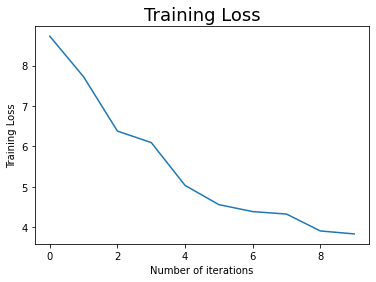

In [ ]:
import matplotlib.pyplot as plt
#visualizing the change in error function
plt.plot(train_error) 
plt.title("Training Loss",size=18)
plt.xlabel("Number of iterations") 
plt.ylabel("Training Loss") 
plt.show() 

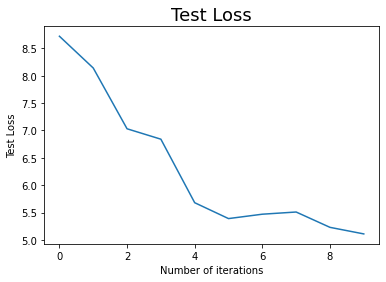

In [ ]:
import matplotlib.pyplot as plt
#visualizing the change in error function
plt.plot(test_error) 
plt.title("Test Loss",size=18)
plt.xlabel("Number of iterations") 
plt.ylabel("Test Loss") 
plt.show() 

Here, as we see, the loss for the train and test data decreases monotonically over each epoch
and thus increases the performance of the model.

Similarly, we can see that the accuracies of both the train and test data also increase
monotonically, thus signifying an increase in the performance of the model.

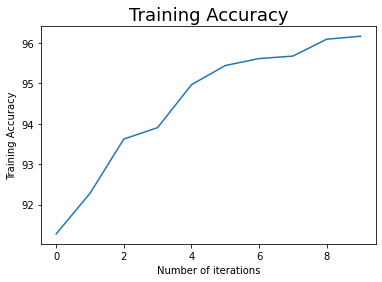

In [ ]:
import matplotlib.pyplot as plt
#visualizing the change in error function
plt.plot(train_acc) 
plt.title("Training Accuracy",size=18)
plt.xlabel("Number of iterations") 
plt.ylabel("Training Accuracy") 
plt.show() 

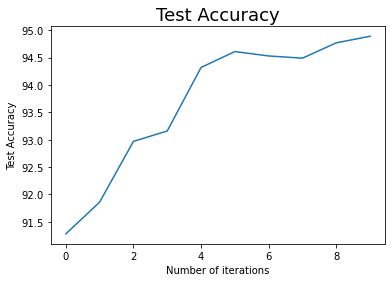

In [ ]:
import matplotlib.pyplot as plt
#visualizing the change in error function
plt.plot(test_acc) 
plt.title("Test Accuracy",size=18)
plt.xlabel("Number of iterations") 
plt.ylabel("Test Accuracy") 
plt.show() 